In [8]:
import json
import csv

import sys
sys.path.append("../../")
#sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

torch.set_default_tensor_type(torch.DoubleTensor)

In [9]:
import implicitmodules.torch as dm

from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian

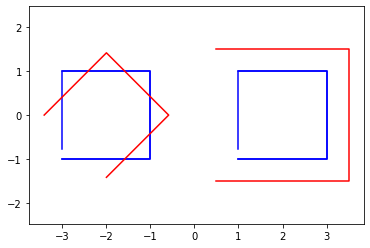

In [10]:
a = 1.
import copy
shape0 = torch.tensor([[-a, -a], [a, -a], [a, a], [-a, a]]) - torch.tensor([2., 0.])
N = 10
X = torch.linspace(-a, a, N)
Z = torch.flip(X, dims=[0])
X = X[:-1]
Z = Z[:-1]
Y = torch.zeros_like(X)

shapebase = torch.cat([torch.stack([X,Y-a], dim=1), torch.stack([Y+a, X], dim=1), torch.stack([Z,Y+a], dim=1), torch.stack([Y-a, Z], dim=1)])

shape0_boundary =  copy.copy(shapebase)- torch.tensor([2., 0.])
shape0_boundary.requires_grad_()
shape0.requires_grad_()
a=1.
shape1 = torch.tensor([[-a, -a], [a, -a], [a, a], [-a, a]]) + torch.tensor([2., 0.])

shape1_boundary =  copy.copy(shapebase)+ torch.tensor([2., 0.])
shape1_boundary.requires_grad_()
shape1.requires_grad_()

a = math.sqrt(2)
target0 = torch.tensor([[0., -a], [a, 0.], [0., a], [-a, 0.]]) -torch.tensor([2., 0.])

X = torch.linspace(-a, a, N)
Z = torch.flip(X, dims=[0])
X = X[:-1]
Z = Z[:-1]
Y = torch.zeros_like(X)

target0.requires_grad_()

a=1.5
target1 = torch.tensor([[-a, -a], [a, -a], [a, a], [-a, a]]) + torch.tensor([2., 0.])
target1.requires_grad_()

scale_scaling = 2.
scaling = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[2., 0.]], requires_grad=True))
scale_rotation = 2.
rotation = dm.DeformationModules.LocalRotation(2, scale_rotation, gd=torch.tensor([[-2., 0.]], requires_grad=True))

#boundary0 = dm.MultiShape.Boundary(shape0)
#boundary1 = dm.MultiShape.Boundary(shape1)

boundary0 = dm.MultiShape.Boundary(shape0_boundary)
boundary1 = dm.MultiShape.Boundary(shape1_boundary)

source_deformable0 = dm.Models.DeformablePoints(shape0)
source_deformable1 = dm.Models.DeformablePoints(shape1)
target_deformable0 = dm.Models.DeformablePoints(target0)
target_deformable1 = dm.Models.DeformablePoints(target1)


plt.plot(shape0[:,0].detach(), shape0[:,1].detach(), '-b')
plt.plot(shape1[:,0].detach(), shape1[:,1].detach(), '-b')
plt.plot(shape0_boundary[:,0].detach(), shape0_boundary[:,1].detach(), '-b')
plt.plot(shape1_boundary[:,0].detach(), shape1_boundary[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '-r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '-r')
plt.axis('equal')
plt.show()


attach = dm.Attachment.EuclideanPointwiseDistanceAttachment()

shoot_solver = 'torch_euler'
shoot_it = 10

compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold([dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), rotation.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), scaling.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])
sigma_bck = 0.5
#constraints = dm.Constraints.Constraints.ConstraintsPointIdentityBase([0, 0], [1, 0], compound_man)
constraints0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man)
constraints1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man)
constraints = dm.Constraints.Constraints.CompoundConstraints([constraints0, constraints1])
model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable0, source_deformable1], [[rotation], [scaling]], [attach, attach], sigma_bck, lam=10., constraints=constraints)

multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, sigma_bck)

In [11]:
multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, 0.1)
multishape.manifold.fill_gd(model.init_manifold.gd)
multishape.manifold.fill_cotan(model.init_manifold.cotan)
Ham = MultiShapeHamiltonian.Hamiltonian_multishape(multishape, constraints)


In [12]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable0, target_deformable1], 40, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

Starting optimization with method Scipy L-BFGS-B
Initial cost={'deformation': 0.0, 'attach': 71.57995925915768}
Time: 15.534258436000528
Iteration: 0
Costs
deformation=17.74592390541175
attach=19.03844164318685
Total cost=36.7843655485986
Time: 19.284757635999995
Iteration: 1
Costs
deformation=14.266587877230464
attach=7.992990449708193
Total cost=22.25957832693866
Time: 26.609030401999917
Iteration: 2
Costs
deformation=11.49042556146685
attach=7.730035108999895
Total cost=19.220460670466746
Time: 34.14615273100026
Iteration: 3
Costs
deformation=11.599017727960831
attach=5.540713191100921
Total cost=17.13973091906175
Time: 42.213707025000986
Iteration: 4
Costs
deformation=11.931087915112531
attach=5.118930922319356
Total cost=17.050018837431885
Time: 49.85196399300003
Iteration: 5
Costs
deformation=12.054845847952045
attach=4.956627658186759
Total cost=17.011473506138806
Time: 57.35930628599999
Iteration: 6
Costs
deformation=12.075280201555104
attach=4.931576273517246
Total cost=17.006

In [13]:
out = model.compute_deformed(shoot_solver, shoot_it)

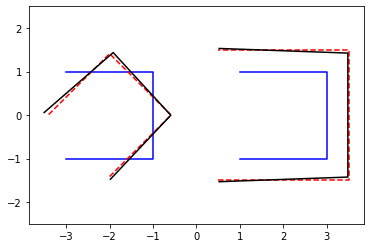

In [14]:
shape0_defo = out[0][0]
shape1_defo = out[1][0]

plt.plot(shape0[:,0].detach(), shape0[:,1].detach(), '-b')
plt.plot(shape1[:,0].detach(), shape1[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '--r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '--r')
plt.plot(shape0_defo[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo[:,0].detach(), shape1_defo[:,1].detach(), '-k')
plt.axis('equal')
plt.show()

In [15]:
fac = 5
grid_resolution = [fac*9, fac*4]
gridmod = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(torch.cat([shape0, shape1])).scale([1.5,2.]), grid_resolution)

In [16]:
grid = gridmod.togrid()

In [17]:
max(gridmod.manifold.gd[:,1])

tensor(2.)

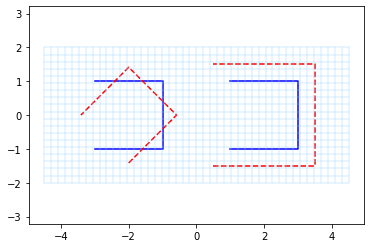

In [18]:

ax = plt.subplot()
plt.plot(shape0[:,0].detach(), shape0[:,1].detach(), '-b')
plt.plot(shape1[:,0].detach(), shape1[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '--r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()

In [19]:

boundary0 = dm.MultiShape.Boundary(shape0_boundary)
boundary1 = dm.MultiShape.Boundary(shape1_boundary)


In [20]:
ind_grid_0 = torch.where(boundary0.isin_label(gridmod.manifold.gd)==True)
ind_grid_1 = torch.where(boundary1.isin_label(gridmod.manifold.gd)==True)
ind_grid_bck = torch.where((boundary0.isin_label(gridmod.manifold.gd)==False)*(boundary1.isin_label(gridmod.manifold.gd)==False)==True)

In [21]:
pts_0 = gridmod.manifold.gd[ind_grid_0].clone().contiguous()
pts_1 = gridmod.manifold.gd[ind_grid_1].clone().contiguous()
pts_bck = gridmod.manifold.gd[ind_grid_bck].clone().contiguous()

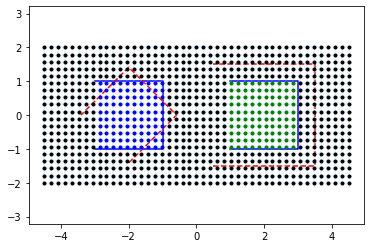

In [22]:

ax = plt.subplot()
plt.plot(shape0[:,0].detach(), shape0[:,1].detach(), '-b')
plt.plot(shape1[:,0].detach(), shape1[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '--r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.plot(pts_0[:,0].detach(), pts_0[:,1].detach(), '.b')
plt.plot(pts_1[:,0].detach(), pts_1[:,1].detach(), '.g')
plt.plot(pts_bck[:,0].detach(), pts_bck[:,1].detach(), '.k')

plt.axis('equal')
plt.show()

In [23]:
module_list = model.modules

In [24]:
for i, mod in enumerate(module_list):
    mod.manifold.fill_gd(model.init_manifold[i].gd)
    mod.manifold.fill_cotan(model.init_manifold[i].cotan)

In [25]:
grid0_deformable = dm.Models.DeformablePoints(pts_0)
grid1_deformable = dm.Models.DeformablePoints(pts_1)
gridbck_deformable = dm.Models.DeformablePoints(pts_bck)
grids_deformable = [grid0_deformable, grid1_deformable, gridbck_deformable]

In [26]:
module_list_grid = []
for mod, defgrid in zip(module_list[:-1], grids_deformable[:-1]):
    module_list_grid.append(dm.DeformationModules.CompoundModule([mod[0], defgrid.silent_module, *mod[1:]]))
module_list_grid.append(dm.DeformationModules.CompoundModule([*module_list[-1], grids_deformable[-1].silent_module]))

In [27]:

compound_man_grid = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold([dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), grid0_deformable.silent_module.manifold.clone(requires_grad=True), rotation.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), grid1_deformable.silent_module.manifold.clone(requires_grad=True), scaling.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True), gridbck_deformable.silent_module.manifold.clone(requires_grad=True)])])
sigma_bck = 0.1
#constraints = dm.Constraints.Constraints.ConstraintsPointIdentityBase([0, 0], [1, 0], compound_man)
constraints0_grid = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man_grid)
constraints1_grid = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man_grid)
constraints_grid = dm.Constraints.Constraints.CompoundConstraints([constraints0_grid, constraints1_grid])


In [28]:
multishape_grid = dm.MultiShape.MultiShape.MultiShapeModules(module_list_grid, sigma_bck)
Ham_grid = MultiShapeHamiltonian.Hamiltonian_multishape(multishape_grid, constraints_grid)
shoot(Ham_grid, shoot_solver, shoot_it)
shape0_defo_grid = Ham_grid.module.modules[0][0].manifold.gd
shape1_defo_grid = Ham_grid.module.modules[1][0].manifold.gd

In [29]:
grid0_deformed_pts = Ham_grid.module.modules[0][1].manifold.gd
grid1_deformed_pts = Ham_grid.module.modules[1][1].manifold.gd
gridbck_deformed_pts = Ham_grid.module.modules[2][-1].manifold.gd

In [30]:
gridmod.manifold.gd[ind_grid_0] = grid0_deformed_pts.clone()
gridmod.manifold.gd[ind_grid_1] = grid1_deformed_pts.clone()
gridmod.manifold.gd[ind_grid_bck] = gridbck_deformed_pts.clone()

In [31]:
grid_deformed = gridmod.togrid()

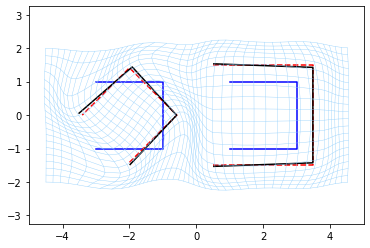

In [32]:

ax = plt.subplot()
plt.plot(shape0[:,0].detach(), shape0[:,1].detach(), '-b')
plt.plot(shape1[:,0].detach(), shape1[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '--r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '--r')
plt.plot(shape0_defo_grid[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo_grid[:,0].detach(), shape1_defo[:,1].detach(), '-k')

dm.Utilities.plot_grid(ax, grid_deformed[0], grid_deformed[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()